# Model Training & Evaluation

In [1]:
import torch
from os import path
from torchinfo import summary

# Dataset & Dataloaders
from data.dataset import *
from data.visualize import *

# Models
from models import *

# Training & Hyperparameter Optimization
from trainer import Trainer, OptunaCallback

import optuna
from optuna.trial import Trial
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_intermediate_values, plot_timeline

from config import *
from utils import set_device, set_seed

set_device()
seed = set_seed()

Using device = cpu
Using seed = 42


## Training

In [ ]:
dataset = LeakNetDataset(with_distance=True)
datasets = get_datasets(dataset)
train_loader, val_loader, test_loader = get_dataloaders(*datasets, collate_fn)

In [10]:
model = LeakNetModel(dataset.n_features, aggregation_func="logavgexp", learning_rate=1e-2)

In [4]:
summary(model, input_data=next(iter(train_loader))[0])

Layer (type:depth-idx)                        Output Shape              Param #
LeakNetModel                                  [32, 1]                   --
├─FCNFeatureExtractor: 1-1                    [32, 32, 220]             --
│    └─Sequential: 2-1                        [32, 32, 220]             --
│    │    └─ConvBlock: 3-1                    [32, 32, 220]             608
│    │    └─ConvBlock: 3-2                    [32, 64, 220]             10,432
│    │    └─ConvBlock: 3-3                    [32, 32, 220]             6,240
├─MILConjunctivePooling: 1-2                  [32, 220, 1]              --
│    └─PositionalEncoding: 2-2                [32, 220, 32]             --
│    └─Dropout: 2-3                           [32, 220, 32]             --
│    └─Sequential: 2-4                        [32, 220, 1]              --
│    │    └─Linear: 3-4                       [32, 220, 8]              264
│    │    └─Tanh: 3-5                         [32, 220, 8]              --
│    │    └

In [11]:
trainer = Trainer(150, show_progress_bar=True, progress_bar_refresh_rate=10)
trainer.fit(model, train_loader, val_loader)

Epoch 10/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 20/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 30/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 40/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 50/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 60/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 70/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 80/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 90/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 100/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 110/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 120/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 130/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 140/150:   0%|          | 0/2 [00:00<?, ?batches/s]

Epoch 150/150:   0%|          | 0/2 [00:00<?, ?batches/s]

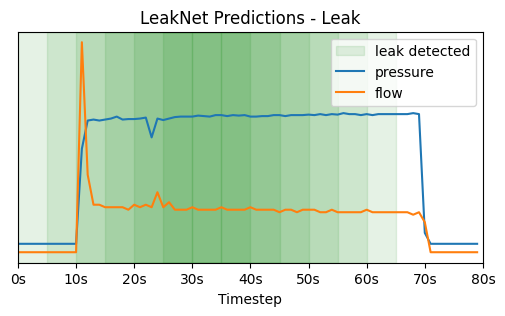

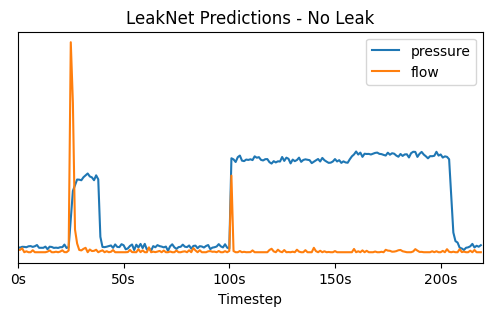

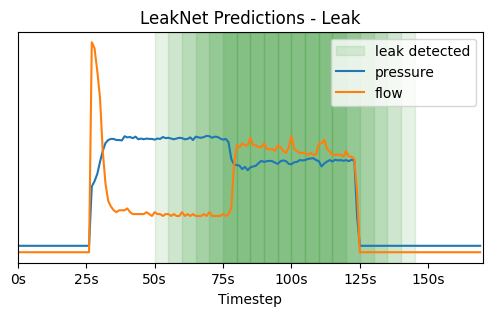

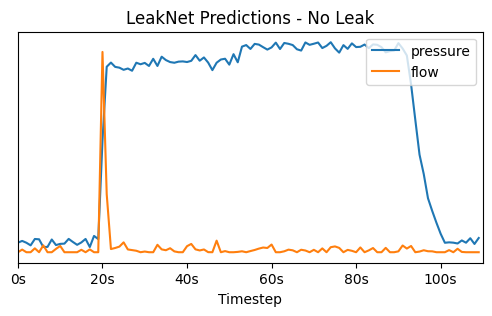

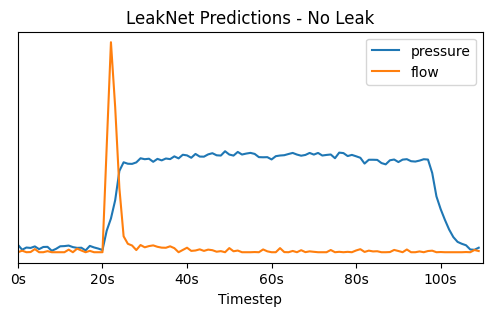

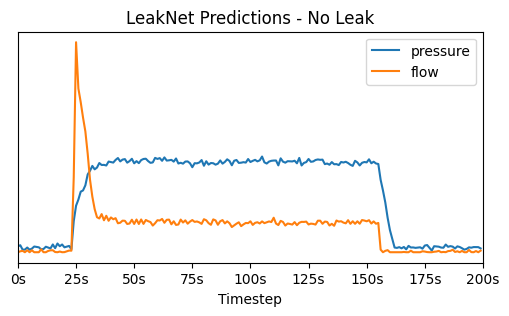

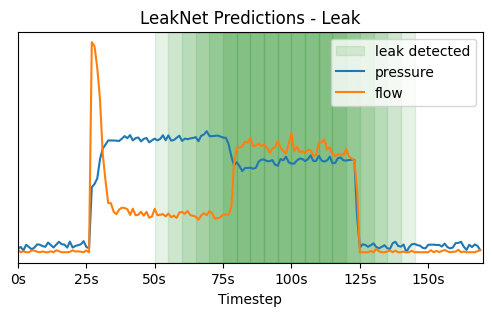

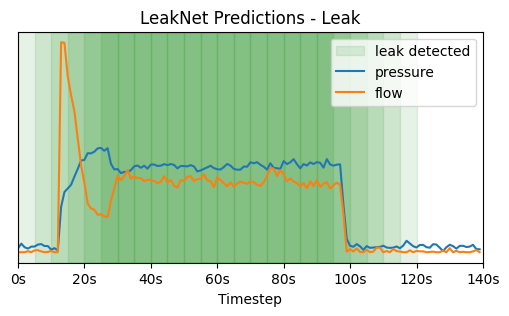

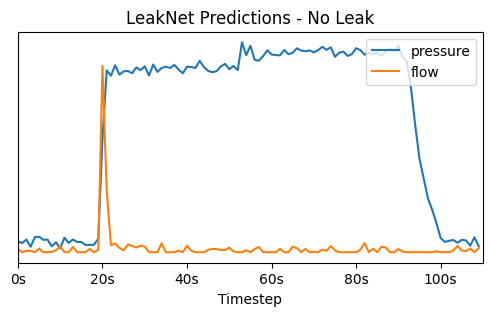

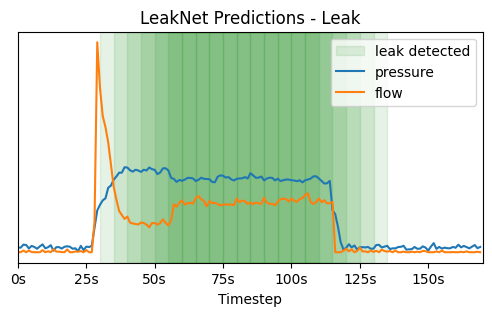

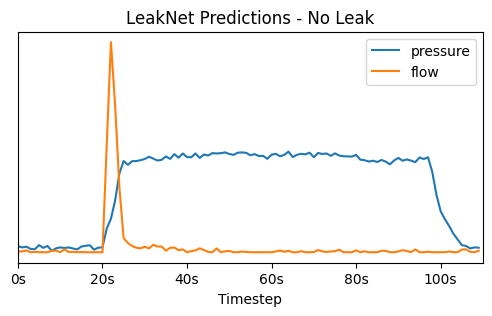

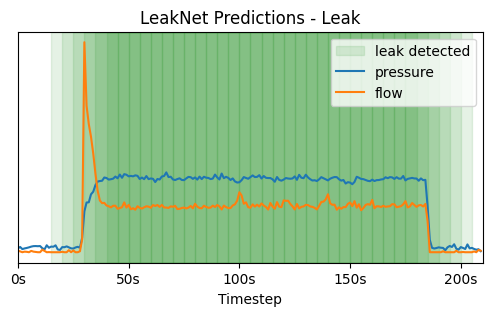

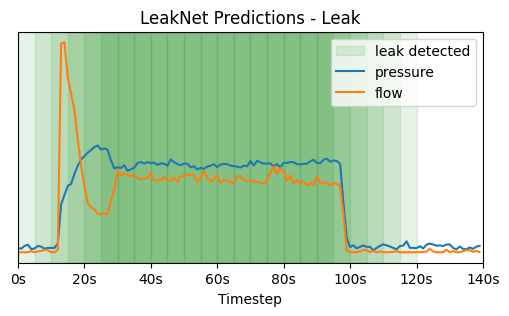

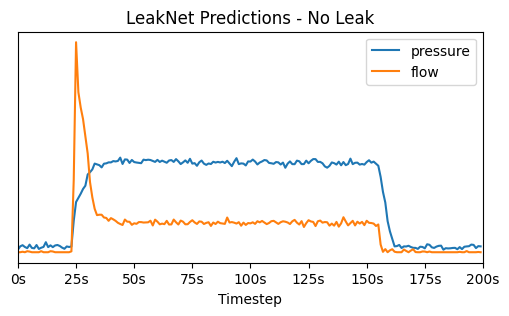

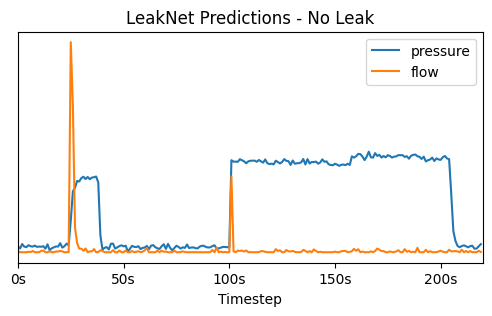

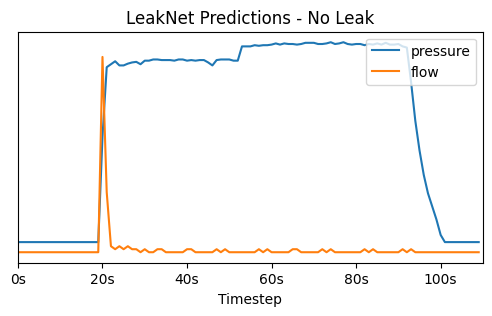

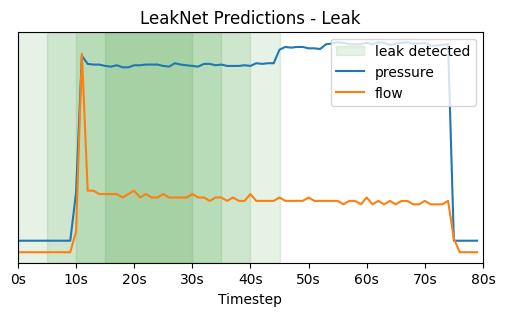

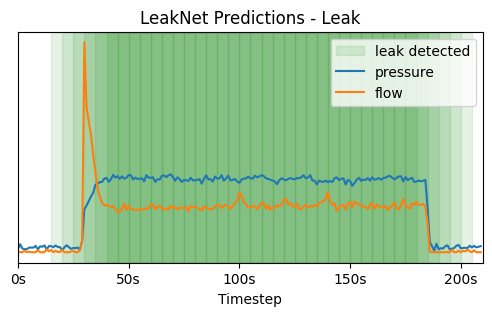

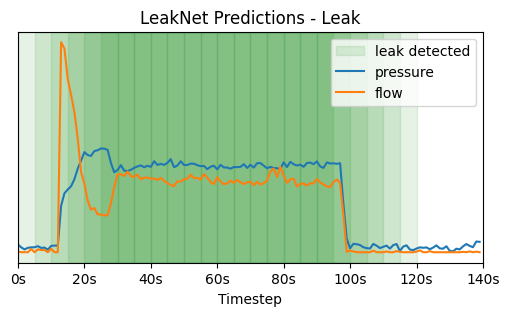

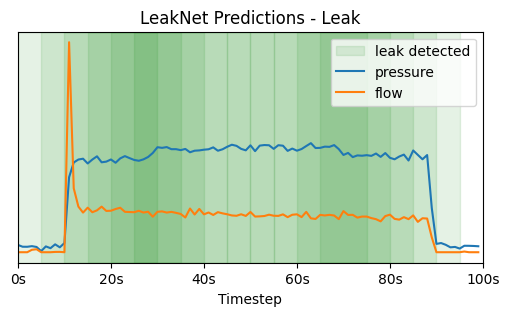

In [12]:
for batch in datasets[2]:
    x, y_true = batch
    windows = x.unfold(0, 30, 5).transpose(1, 2)
    y_pred = trainer.predict(model, windows)
    
    plot_window_predictions(x, y_pred, y_true, window_size=30, stride=5, threshold=0.5)
    
for batch in datasets[1]:
    x, y_true = batch
    windows = x.unfold(0, 30, 5).transpose(1, 2)
    y_pred = trainer.predict(model, windows)
    
    plot_window_predictions(x, y_pred, y_true, window_size=30, stride=5, threshold=0.5)

In [38]:
production_model_path = path.join(MODELS_DIR, "leaknet.pt")
print(f"Saving model to {production_model_path}")
scripted_model = model.to_torchscript()
scripted_model.save(production_model_path)

Saving model to /home/nikas/projects/irrigo/ml-model/models/leaknet.pt


In [10]:
!torch-model-archiver --model-name leaknet \
                       --version 1.0 \
                       --serialized-file ../models/leaknet.pt \
                       --handler ../deployment/handler \
                       --export-path ../deployment/model-store \
                       --force

WARNING - Overwriting ../deployment/model-store/leaknet.mar ...


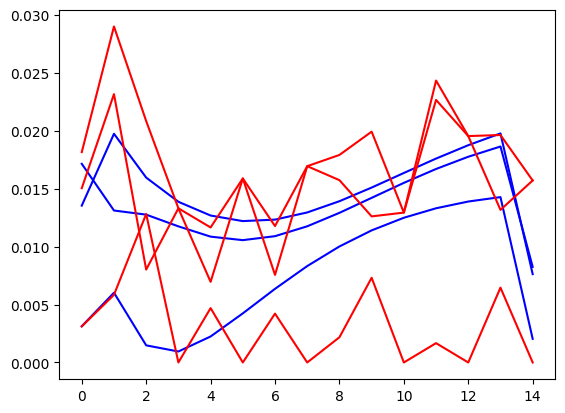

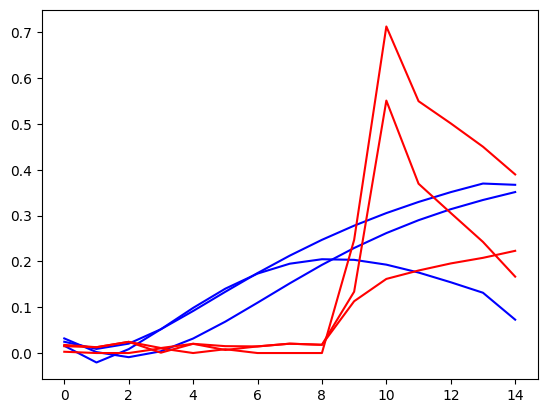

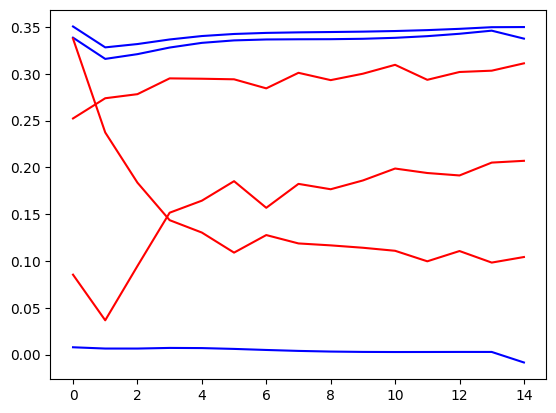

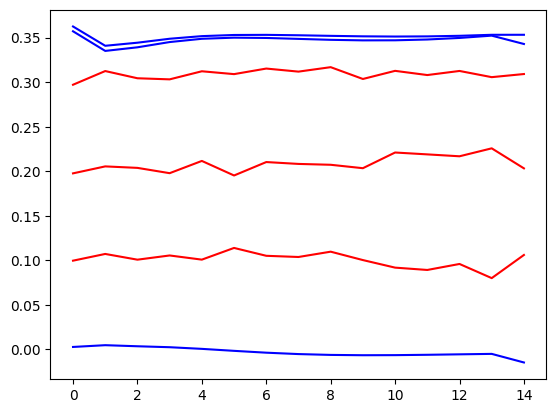

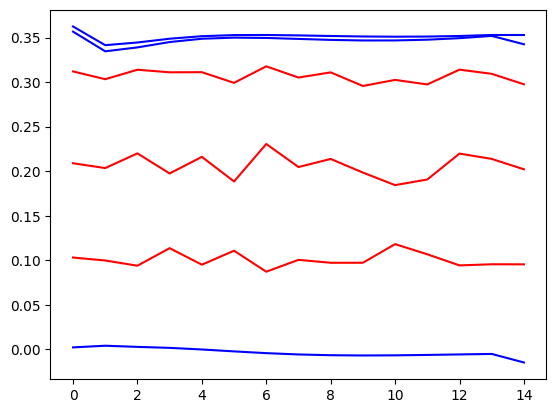

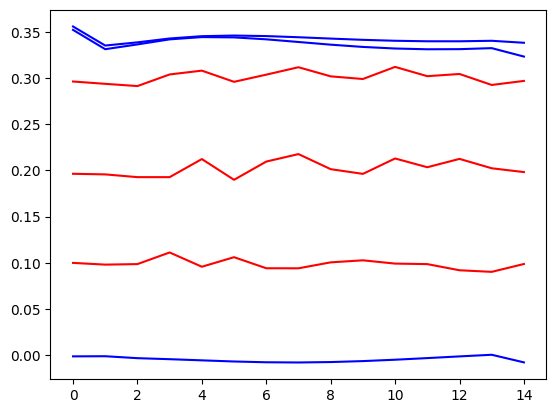

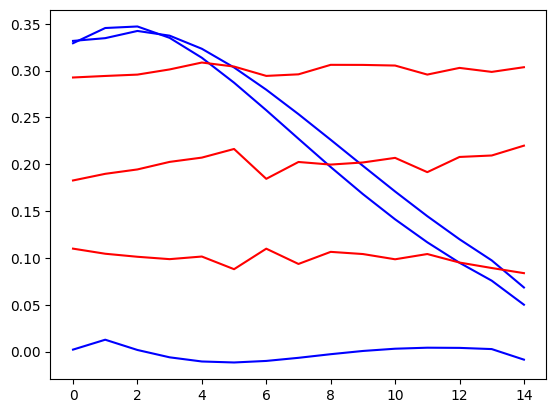

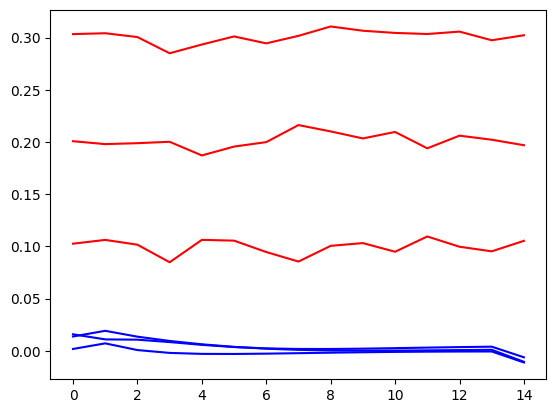

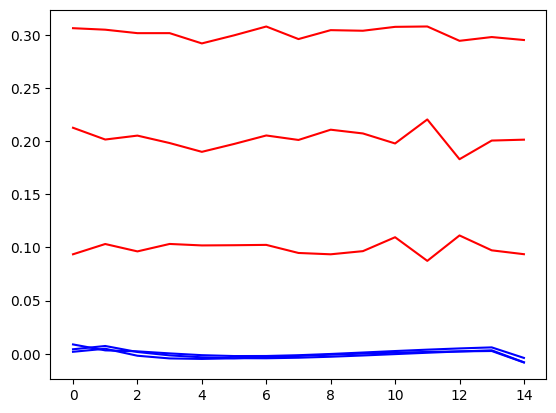

KeyboardInterrupt: 

In [17]:
out = trainer.test(model, train_loader)
import matplotlib.pyplot as plt

for x, y in train_loader:
    for x, out in zip(x, out):
        plt.plot(out, color='blue')
        plt.plot(x, color='red')
        plt.show()

In [4]:
def objective_leaknet_rnn(trial: Trial):
    
    lr = trial.suggest_float('learning_rate', 1e-4, 1, log=True)
    latent_dim = trial.suggest_categorical("latent_dim", [8, 16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    rnn_type = trial.suggest_categorical("rnn_type", ["GRU", "LSTM"])
    cnn_filters = trial.suggest_int("cnn_filters", 1, 6)
    kernel_size = trial.suggest_int("kernel_size", 3, 7, step=2)
    
    if num_layers != 1:
        dropout = trial.suggest_float('dropout', 0.01, 0.5, log=True)
    else:
        dropout = 0.0
        
    # Get data loaders
    datasets = get_classifiers_datasets(leaks_dataset)
    train_loader, val_loader, _ = get_dataloaders(*datasets, BATCH_SIZE)
    
    # define model
    model = LeakNetCRNN(INPUT_DIM, latent_dim, num_layers, dropout=dropout, rnn=rnn_type, cnn_filters=cnn_filters, kernel_size=kernel_size, learning_rate=lr, batch_size=BATCH_SIZE)
    trainer = Trainer(EPOCHS, show_progress_bar=False)
    
    trainer.fit(model, train_loader, val_loader, callbacks=[OptunaCallback(trial)])
    
    model_path = path.join(CHECKPOINTS_DIR, f"{trial.study.study_name}_trial_{trial.number}.pt")
            
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": model.optimizer.state_dict(),
    }, model_path)
     
    trial.set_user_attr("model_name", type(model).__name__)
    trial.set_user_attr("history", trainer.history)
    trial.set_user_attr("model_path", model_path)
    trial.set_user_attr("hparams", model.hparams)
    
    return trainer.history['val_loss'][-1]


In [7]:
study = optuna.create_study(
    study_name="LeakNetCRNN",
    storage="sqlite:///studies.db",
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=optuna.pruners.HyperbandPruner(max_resource=EPOCHS))

[I 2025-01-29 18:18:21,371] A new study created in RDB with name: LeakNetCRNN


In [8]:
study.optimize(objective_leaknet_rnn, n_trials=150, n_jobs=-1)

[I 2025-01-29 18:18:30,490] Trial 13 pruned. 
[I 2025-01-29 18:18:30,573] Trial 9 pruned. 
[I 2025-01-29 18:18:31,488] Trial 2 pruned. 
[I 2025-01-29 18:18:32,525] Trial 15 pruned. 
[I 2025-01-29 18:18:32,878] Trial 3 pruned. 
[I 2025-01-29 18:18:34,153] Trial 6 pruned. 
[I 2025-01-29 18:18:34,772] Trial 8 pruned. 
[I 2025-01-29 18:18:38,480] Trial 17 pruned. 
[I 2025-01-29 18:18:40,275] Trial 11 pruned. 
[I 2025-01-29 18:18:40,904] Trial 7 pruned. 
[I 2025-01-29 18:18:42,839] Trial 19 pruned. 
[I 2025-01-29 18:18:43,618] Trial 22 pruned. 
[I 2025-01-29 18:18:49,125] Trial 23 pruned. 
[I 2025-01-29 18:18:51,103] Trial 25 pruned. 
[I 2025-01-29 18:18:52,477] Trial 20 pruned. 
[I 2025-01-29 18:18:57,489] Trial 28 pruned. 
[I 2025-01-29 18:19:01,408] Trial 29 pruned. 
[I 2025-01-29 18:19:11,448] Trial 31 pruned. 
[I 2025-01-29 18:19:25,926] Trial 4 finished with value: 1.820309042930603 and parameters: {'learning_rate': 0.00024155383055293256, 'latent_dim': 16, 'num_layers': 1, 'rnn_type'

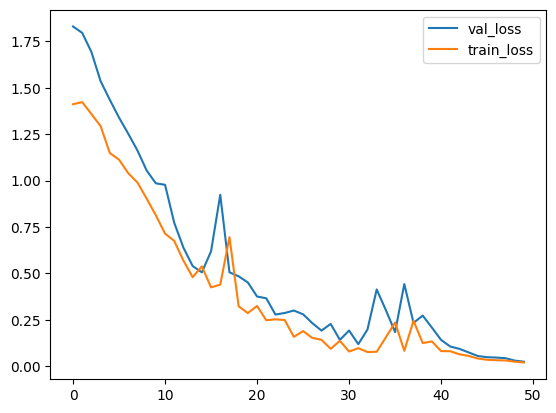

In [9]:
plot_history_from_study(study)

In [10]:
plot_optimization_history(study)

In [11]:

plot_param_importances(study)

In [12]:
plot_intermediate_values(study)

In [13]:
plot_timeline(study)